In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from scipy.integrate import solve_ivp


In [6]:
f_modul = lambda t,X, A, m, w, gamma: np.array([X[1] - 1 - m*np.cos(w*t) ,
                            (A - X[1]*(1 + np.exp(X[0])))*gamma])

Jacf_modul = lambda t,X,gamma: np.array([[0,1],
                                                [-gamma*X[1]*np.exp(X[0]),-gamma*(1+np.exp(X[0]))]])
s_modul = lambda t,X,A,m,w,gamma : X[1] - 1 - m
GradS_modul = lambda t,X,A,m,w,gamma: np.array([0,1])

s_modul2 = lambda t,X, A,m,w,gamma: gamma*(A - X[1]*(1+np.exp(X[0])))
GradS_modul2 = lambda t,X,A,m,w,gamma: np.array([-gamma*X[1]*np.exp(X[0]),-gamma*(1+np.exp(X[0]))])

ds_T_modul = lambda t,X: 0.0

In [7]:
def big_system(t, Y_M, f, Jacf, dim, A, m, w, gamma):
    # Solving numerically the initial value problem (dy/dt,dM/dt = (f(t,y),Gradf*M) 
    M = Y_M[dim:].reshape((dim, dim), order = 'F')  # Reshape the flat array back into a dim^2 x dim matrix
    dM_dt = Jacf(t,Y_M[:dim],gamma) @ M  # Compute the matrix derivative
    
    return np.concatenate([f(t, Y_M[:dim],A,m,w,gamma),dM_dt.flatten(order = 'F')])

In [19]:
def Newton_orbite_T_known(f, X_0,T,A, m, w, gamma, Jacf, Max_iter, epsilon):
    
    dim = np.shape(X_0)[0] #The problem's dimension
    #________________________________INITIALISATION_____________________________________
    k, Xstar_0 = 0, X_0
    # sol = solve_ivp(lambda t, X: f(t,X, A, m, w, gamma),t_span=[0.0, T], y0=X_0, t_eval=[T],
                    #  method='RK45', option={"rtol": 1e-5,"atol":1e-7})
    

    X_by_iter , Norm_DeltaX, Norm_B = np.zeros((Max_iter+1,dim)),np.zeros((Max_iter+1)),np.zeros((Max_iter+1))
    X_by_iter[0,:] = Xstar_0
    Norm_DeltaX[0] = norm_delta_X = 1 # 
    # Norm_B[0] = norm_B = np.linalg.norm(sol.y[:,-1] - Xstar_0, ord=2)

    #_____________Newton iteration loop____________________
    while (norm_delta_X > epsilon  and k<Max_iter):
        
        #- Solving numerically the initial value problem (dy/dt,dM/dt = (f(t,y),Gradf*M)
        M = np.eye(dim) #Initialisation of the monodromy matrix
        X_M = np.concatenate([Xstar_0, M.flatten()])
        #  Solve the system of ODEs
        big_sol= solve_ivp(lambda t, X: big_system(t, X, f, Jacf, dim, A, m, w, gamma), [0.0,T], y0=X_M,
                            method='RK45',**{"rtol": 1e-5,"atol":1e-7}) #It's a function of t
        
        Xstar_T = big_sol.y[:dim,-1] # The solution at T
        M = big_sol.y[dim:,-1] #We take M(T)
        M = M.reshape((dim,dim), order='F') #Back to the square matrix format
        #______Computation of DeltaX and DeltaT_____
        
        Delta_X = np.linalg.solve(M - np.eye(dim),-(Xstar_T - Xstar_0))

        # Delta_X = np.linalg.lstsq(Mat, -B, rcond=None)[0]
        

        #Updating
        Xstar_0 += Delta_X

        norm_delta_X = np.linalg.norm(Delta_X)
        norm_B = np.linalg.norm(Xstar_T - Xstar_0)

        print("Iteration", k, "\n")
        print("Norm(Dx) = ", norm_delta_X,"\n")
        X_by_iter[k,:] = Xstar_0
        Norm_DeltaX[k] = norm_delta_X
        Norm_B[k] = norm_B
        k += 1
        

    # eigenvalues, eigenvectors = np.linalg.eig(monodromy)
    return k, X_by_iter, Norm_DeltaX,Norm_B, M

In [20]:
Max_iter,epsilon = 100, 1e-12
A = 1.1
m = 2.5e-2
gamma = 1e-3
w = 1e-2
params = (A,m,w,gamma)
L0, D0 = -6.1, 0.98#-np.log(A-1)+0.001, 1.005 #-5. ,1#0.9805 # m+1
X0 = np.array([L0,D0])
T0 = 2*np.pi/w

In [ ]:
k, XX,Norm_DeltaX,Norm_B, M = Newton_orbite_T_known(f_modul, X0,T0, A, m, w, gamma, Jacf_modul, Max_iter, epsilon)


In [ ]:
np.set_printoptions(precision=18)
print(XX[k-1])
k

## Ploting

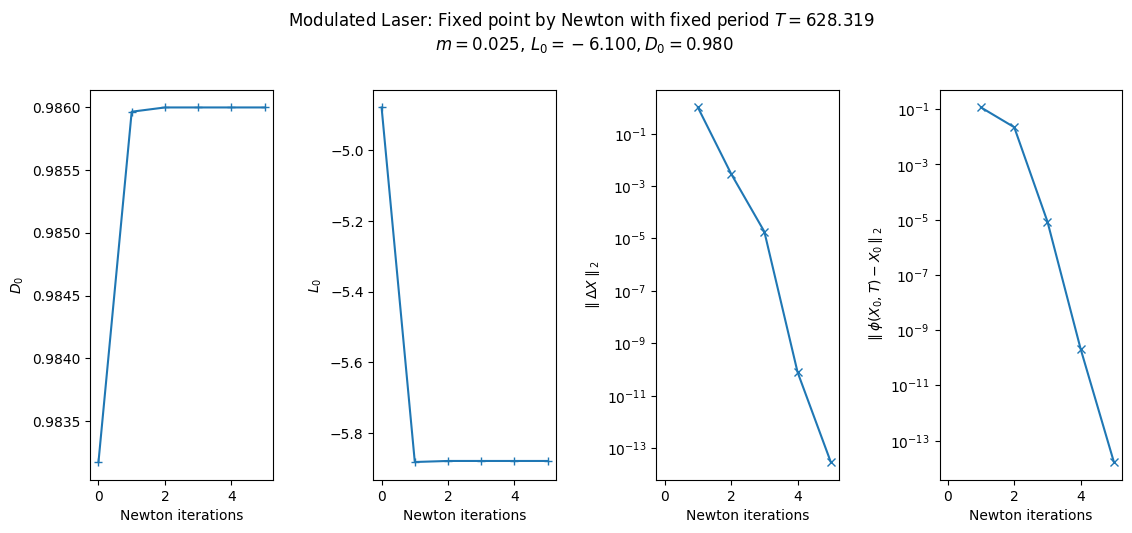

In [22]:
fig, ax = plt.subplots(1,4,sharex='all')
Tab = np.asarray(XX[:k])
ax[0].plot(np.arange(k),Tab[:,1],'+-')
ax[0].set_xlabel("Newton iterations")
ax[0].set_ylabel(f"$D_0$")

ax[1].plot(np.arange(k),Tab[:,0],'+-')
ax[1].set_xlabel("Newton iterations")
ax[1].set_ylabel(f"$L_0$")
ax[2].semilogy(np.arange(1,k),Norm_DeltaX[1:k],'x-')
ax[2].set_xlabel("Newton iterations")
ax[2].set_ylabel(f"$\parallel \Delta X \parallel_2$")
ax[3].semilogy(np.arange(1,k),Norm_B[1:k],'x-')
ax[3].set_xlabel("Newton iterations")
ax[3].set_ylabel(f"$\parallel \phi(X_0, T) - X_0 \parallel_2$")
fig.set_size_inches((12,10))
fig.suptitle(f'Modulated Laser: Fixed point by Newton with fixed period $T=%.3f$ \n $m = %.3f$, $L_0 = %.3f, D_0= %.3f $' % (T0, m, L0,D0))
# fig.suptitle('(Rescaled approach Laser model :\n I0 = %.3f, D0 %.3f} )' % (I0,D0))

fig.subplots_adjust(left=0.09, bottom=0.51, right=0.95, top=0.90, hspace=0.55, wspace=0.55)
plt.savefig(f'./Results/Modulated_Laser_T_known_m_{str(m)}.png')

### Poincaré section

In [ ]:
# visual check #2: Poincare section
	# y_init=MyTimestepper.y_last
	# t_init=MyTimestepper.t_init
n_per=1000
npts_par_per=40
t_end=T0*n_per
# 1 point per period
t_eval=np.linspace(0,t_end,n_per+1) 


# sol=MyTimestepper.integrate([0,t_end],X0,t_eval=t_eval)

sol = solve_ivp(fun=f_modul,t_span=[0.0, t_end],
                t_eval=t_eval, 
                y0=X0, method='RK45', 
                args = params,
                **{"rtol": 1e-5,"atol":1e-7}
                )
print(t_eval.shape,sol.y[0,:].shape)


fig1=plt.figure()
ax1=fig1.add_subplot(2,1,1)
ax1.plot(sol.y[0,:],sol.y[1,:],'.',markersize=2)
plt.tight_layout()


## Solving the ODE with the found fixed point 

In [8]:
X0 = np.array(XX[k-1])
sol = solve_ivp(fun=f_modul,t_span=[0.0, 4*T0],
                t_eval=np.linspace(0.0,4*T0, 1000), 
                y0=X0, method='RK45', 
                args = params,
                **{"rtol": 1e-5,"atol":1e-7}
                )

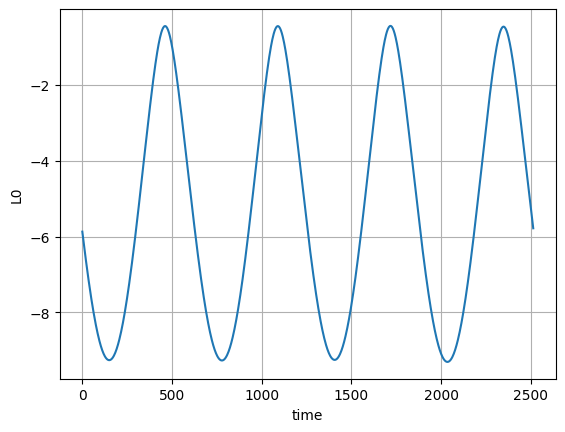

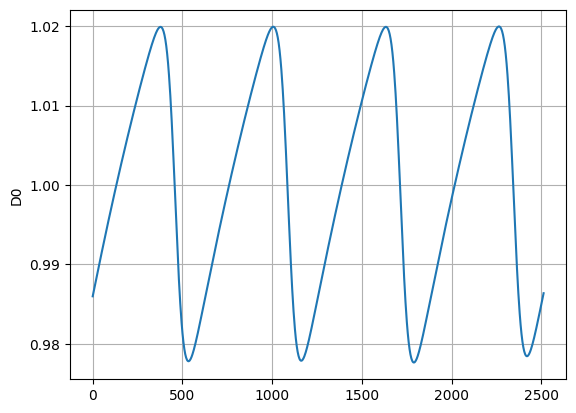

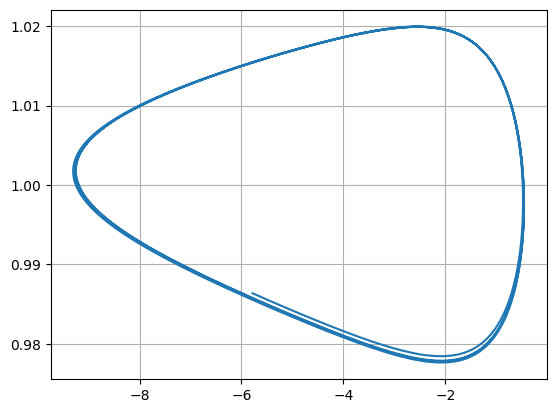

In [9]:
X = sol.y 
times_intervall = sol.t
plt.plot(times_intervall,X[0,:])
# plt.xlim([0,1100])
plt.grid()
plt.xlabel("time")
plt.ylabel("L0")
plt.show()

plt.plot(times_intervall,X[1,:])
plt.ylabel("D0")
plt.grid()
plt.show()

plt.plot(X[0,:], X[1,:])
plt.grid()


In [ ]:
eigvalues, eigvec = np.linalg.eig(M)
eigvalues
# Norm_B[k-1]